<a href="https://colab.research.google.com/github/kushalshah0/colab_tools/blob/main/ai-generated-phishing-emails-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 Phishing Email Detection using BERT - Project Notebook

## 📌 Table of Contents

1. [Project Overview](#project-overview)
2. [Environment Setup](#environment-setup)
3. [Data Loading and Sampling](#data-loading-and-sampling)
4. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
    - [Label Distribution](#label-distribution)
    - [Text Length Analysis](#text-length-analysis)
    - [Special Characters & URL Analysis](#special-characters--url-analysis)
    - [Top Words in Phishing Emails](#top-words-in-phishing-emails)
5. [Data Preprocessing](#data-preprocessing)
    - [Lowercasing](#lowercasing)
    - [Stopwords Removal (Optional)](#stopwords-removal-optional)
6. [Train-Validation-Test Split (70/10/20)](#train-validation-test-split-701020)
7. [Baseline Models (LSTM & GRU)](#baseline-models-lstm--gru)
    - [LSTM Model Training and Evaluation](#lstm-model-training-and-evaluation)
    - [GRU Model Training and Evaluation](#gru-model-training-and-evaluation)
8. [Tokenization using BERT Tokenizer](#tokenization-using-bert-tokenizer)
9. [Dataset Preparation for PyTorch](#dataset-preparation-for-pytorch)
10. [Model Setup with BERT](#model-setup-with-bert)
11. [Define Training Arguments](#define-training-arguments)
12. [Trainer Setup and Metrics](#trainer-setup-and-metrics)
13. [Model Training](#model-training)
14. [Evaluate on Validation Set](#evaluate-on-validation-set)
15. [Evaluate on Test Set](#evaluate-on-test-set)
    - [Accuracy, Precision, Recall, F1-Score](#accuracy-precision-recall-f1-score)
    - [Confusion Matrix](#confusion-matrix)
16. [Plot Metrics (Accuracy/Loss vs Epoch)](#plot-metrics-accuracyloss-vs-epoch)
17. [Saving the Model and Tokenizer](#saving-the-model-and-tokenizer)
18. [Load Trained Model for Inference](#load-trained-model-for-inference)
19. [Model Comparison](#model-comparison)
20. [Next Steps and Improvements](#next-steps-and-improvements)

## Project overview
With the rapid rise of AI-generated content, phishing emails have become more sophisticated and harder to detect through traditional methods. Attackers now craft deceptive messages that closely mimic legitimate communication, putting individuals and organizations at risk of data theft, financial fraud, and identity compromise. This project aims to address the growing threat by developing an intelligent phishing email detection system using BERT, a powerful transformer-based language model. By analyzing the textual content of emails, our model learns to distinguish between phishing and legitimate messages with high accuracy, helping to automate and enhance email security on a large scale.

In [ ]:
import pandas as pd
import re
import torch

#libraries for data explore
import seaborn as sns
import matplotlib.pyplot as plt

#libraries for Model training and evaluation
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [9]:
#@title Mount Google Drive (Required for Saving Progress)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#@title Define Project Save Directory
import os

BASE_DIR = "/content/drive/MyDrive/Detect_AI_Phishing_Project"
os.makedirs(BASE_DIR, exist_ok=True)

print("All outputs will be saved to:", BASE_DIR)


All outputs will be saved to: /content/drive/MyDrive/Detect_AI_Phishing_Project


In [ ]:
# Example: Load a CSV dataset
dataset_path = "/content/drive/MyDrive/Detect_AI_Phishing_Project/data/phishing_email.csv"
df = pd.read_csv(dataset_path)

df.shape

(82486, 2)

In [ ]:
# Randomly sample 15,000 rows from the full dataset
#df = df.sample(n=15000, random_state=42).reset_index(drop=True)

#SAMPLE_NAME = "sample1" name the sample according to the drive's update

SAMPLE_NAME = ""

SAMPLE_DIR = f"{BASE_DIR}/{SAMPLE_NAME}"
os.makedirs(SAMPLE_DIR, exist_ok=True)
df.to_csv(f"{SAMPLE_DIR}/{SAMPLE_NAME}.csv", index=False)

print(f"Sample saved to {SAMPLE_DIR}/{SAMPLE_NAME}.csv")

print(df.head())

Sample saved to /content/drive/MyDrive/Detect_AI_Phishing_Project/sample1/sample1.csv
                                       text_combined  label  special_chars
0  gary lawrence murphy garymcanadacom thosstew w...      0              0
1  jkoanihlzkfa shafucm1hinetnet tw vicky ni gary...      1              0
2  power flow software question thanks let walter...      0              0
3  malinda lusk noreengettynorthppwiorg best repl...      1              0
4  ready get hello viagra 1 med struggle mens ere...      1              0


## Preprocess the Data

- **Remove null**
- **Lowercasing** : BERT handles case, but lowercase helps traditional models


# Preprocessing Steps Not Applied (with Justifications)

- **Remove URLs** : URLs are strong indicators of phishing, so we keep them as features.
- **Remove special characters** : Symbols like @, !, $, etc., are commonly used in phishing tactics and should be retained.
- **Remove punctuation** : Punctuation may be part of deceptive formatting or URLs, so we do not remove it.
- **Remove numbers** : Numbers (like fake invoice IDs or OTPs) may signal phishing intent, so we preserve them.
- **Remove stopwords** : Common words may carry phishing signals in certain contexts, so we keep them for now.
- **Remove capital letters** : Capitalization (e.g., “URGENT”) often indicates phishing, so we retain letter casing.
- **Stemming or Lemmatization** : We keep words in their original form to preserve possible phishing-related phrasing.
- **Remove HTML tags** : Some phishing emails use HTML tricks; we want to analyze them if present.
- **Spelling correction** : Typos and misspellings may be deliberate in phishing emails, so we avoid correcting them.



In [ ]:
df.dropna(inplace=True)

df['label'] = df['label'].astype(int)

# Lowercasing only
def clean_text(text):
    return text.lower()

df['text_combined'] = df['text_combined'].apply(clean_text)

In [ ]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  15000 non-null  object
 1   label          15000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 234.5+ KB
None
                                       text_combined  label
0  gary lawrence murphy garymcanadacom thosstew w...      0
1  jkoanihlzkfa shafucm1hinetnet tw vicky ni gary...      1
2  power flow software question thanks let walter...      0
3  malinda lusk noreengettynorthppwiorg best repl...      1
4  ready get hello viagra 1 med struggle mens ere...      1


In [ ]:
df.shape

(15000, 2)

In [ ]:
df.tail()

,text_combined,label
14995,adam tracksler dupjbrycecreativecom way make c...,0
14996,unbeatable interest rates hi tried contacting ...,1
14997,steven bethard tzmfkenpikfgggmailcom sat mar 2...,0
14998,celebrate texas excellence ex students associa...,0
14999,turbine list louise attached recent turbine po...,0


# Explore the dataset

#### Plot Class Distribution

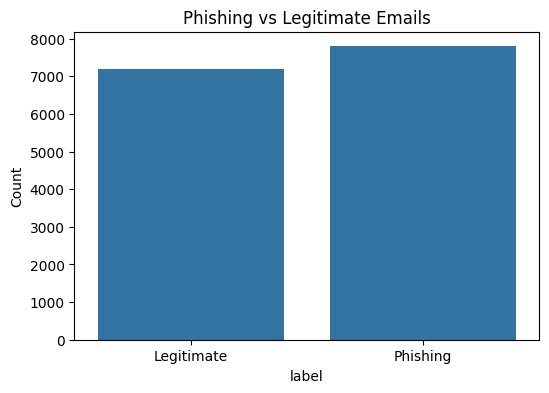

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label') # counts the number of occurrences of each unique value in a column
plt.title('Phishing vs Legitimate Emails')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.ylabel('Count')
plt.show()


#### Email/Text special character Length Distribution by Class
This graph is a boxplot comparing the number of special characters used in legitimate vs phishing emails.

Special characters: ! @ # $ % ^ & * ( ) _ + = { } [ ] : ; " ' < > / ? , . ~ etc.


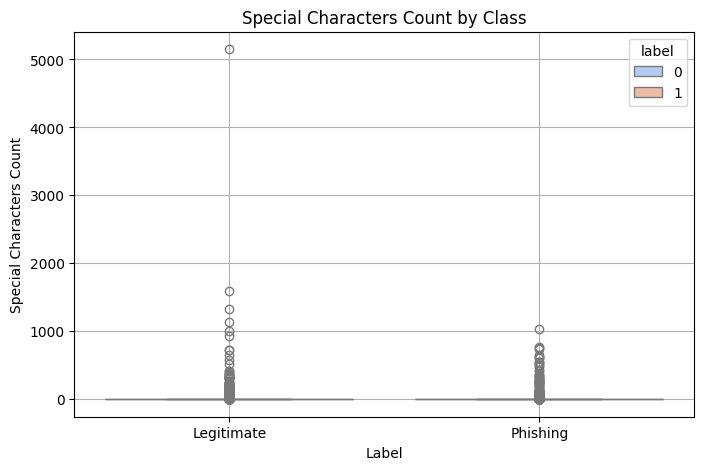

In [ ]:
df['special_chars'] = df['text_combined'].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))

plt.figure(figsize=(8,5))
sns.boxplot(x='label', y='special_chars', data=df, hue='label', palette='coolwarm', dodge=False)

plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.title('Special Characters Count by Class')
plt.xlabel('Label')
plt.ylabel('Special Characters Count')
plt.grid(True)
plt.show()

#### Most Common Words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


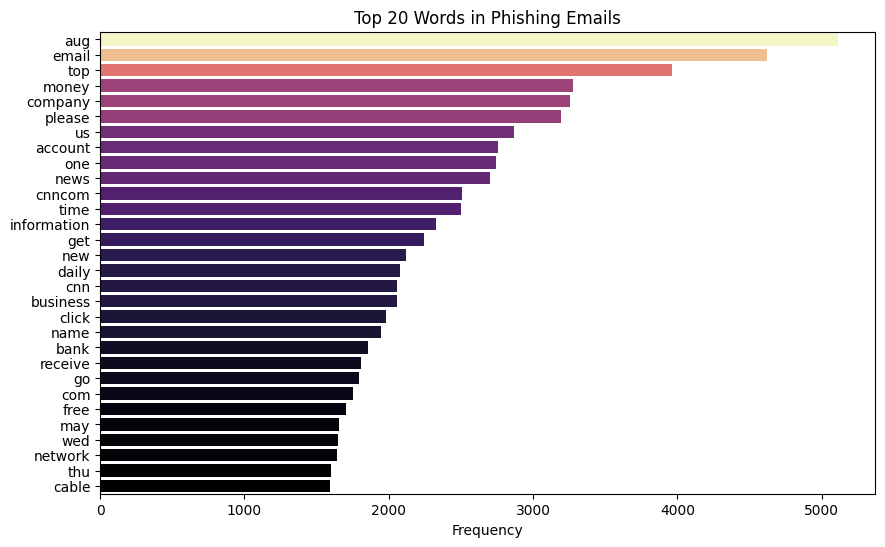

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


stop_words = set(stopwords.words('english'))  #e.g., "the", "is", "and"

# Combine all phishing emails: Joins all texts into one string → converts to lowercase → splits into words
phishing_words = ' '.join(df[df['label']==1]['text_combined']).lower().split() #Selects only phishing emails (where label == 1)

filtered_words = [word for word in phishing_words if word.isalpha() and word not in stop_words] #Alphabetic words (removes numbers, punctuation)

word_freq = Counter(filtered_words).most_common(30)

# Barplot of top words
words, counts = zip(*word_freq)  #Unpacks the 20 most common word–count pairs into two separate lists: words and counts
plt.figure(figsize=(10,6))
sns.barplot(x=list(counts), y=list(words),hue =list(counts), palette='magma',legend=False)
plt.title('Top 20 Words in Phishing Emails')
plt.xlabel('Frequency')
plt.show()

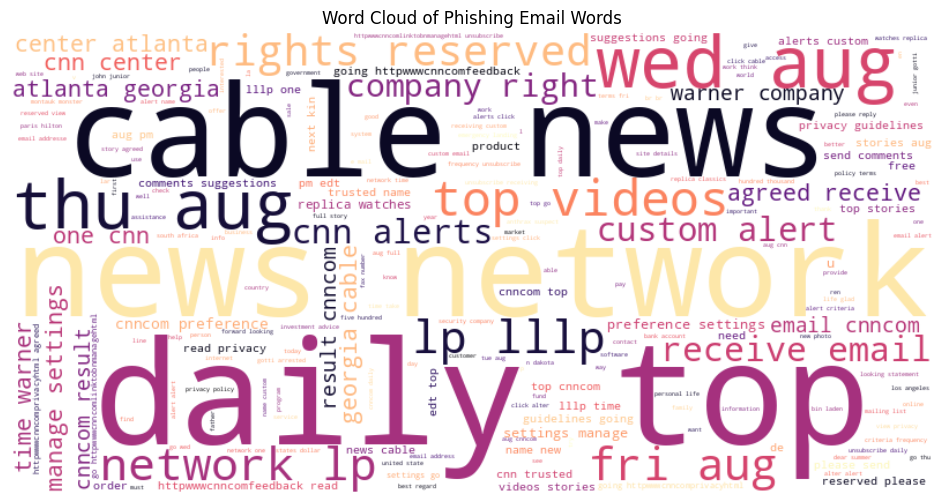

In [ ]:
from wordcloud import WordCloud

# Join all filtered phishing words into a single string
wordcloud_text = ' '.join(filtered_words)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(wordcloud_text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Phishing Email Words')
plt.show()


 ### Split the Dataset in training , validation and test

In [ ]:
from sklearn.model_selection import train_test_split

# 1. First, split out 20% test data

train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(df['text_combined'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42, stratify=df['label'])

# 2. Then split remaining 80% into 70% train and 10% val

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels,
    test_size=0.125,  # 10% of total = 12.5% of the remaining 80%
    random_state=42, stratify=train_val_labels
)


In [ ]:
#@title Imports for LSTM & GRU Baselines
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
#@title Tokenization for LSTM/GRU Baselines
MAX_VOCAB_SIZE = 20000
MAX_SEQ_LEN = 300

# Create DataFrames for RNN models
train_df = pd.DataFrame({'text_combined': train_texts, 'label': train_labels})
val_df = pd.DataFrame({'text_combined': val_texts, 'label': val_labels})
test_df = pd.DataFrame({'text_combined': test_texts, 'label': test_labels})

tokenizer_rnn = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer_rnn.fit_on_texts(train_df["text_combined"])

def encode_texts(texts):
    sequences = tokenizer_rnn.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")

X_train_rnn = encode_texts(train_df["text_combined"])
X_val_rnn   = encode_texts(val_df["text_combined"])
X_test_rnn  = encode_texts(test_df["text_combined"])

y_train = train_df["label"].values
y_val   = val_df["label"].values
y_test  = test_df["label"].values

print("Train DataFrame head:")
display(train_df.head())

Train DataFrame head:


,text_combined,label
0,spamexperts via twitter uiaregitwittercom moni...,0
1,carlos e r vyjwdtrpcautelefonicanet begin pgp ...,0
2,hal blackwell marlingottfrieddaltonuticaodcom ...,1
3,apr 20 wharton final agenda michael vince appr...,0
4,schedule crawler hourahead failure start date ...,0


In [ ]:
#@title Save RNN Tokenizer (LSTM & GRU)
import pickle
import os

with open(f"{BASE_DIR}/{SAMPLE_NAME}/rnn_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer_rnn, f)

print(f"RNN tokenizer saved successfully at: {BASE_DIR}/{SAMPLE_NAME}/rnn_tokenizer.pkl")


RNN tokenizer saved successfully at: /content/drive/MyDrive/Detect_AI_Phishing_Project/sample1/rnn_tokenizer.pkl


In [ ]:
#@title Dataset Class for RNN Models
class RNNDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
#@title Dataloaders for LSTM & GRU
BATCH_SIZE = 64

train_loader_rnn = DataLoader(RNNDataset(X_train_rnn, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader_rnn   = DataLoader(RNNDataset(X_val_rnn, y_val), batch_size=BATCH_SIZE)
test_loader_rnn  = DataLoader(RNNDataset(X_test_rnn, y_test), batch_size=BATCH_SIZE)


In [ ]:
#@title LSTM Model Definition
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.dropout(hidden[-1])
        return torch.sigmoid(self.fc(out))


In [ ]:
#@title GRU Model Definition
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.gru(x)
        out = self.dropout(hidden[-1])
        return torch.sigmoid(self.fc(out))


In [ ]:
#@title Define train_rnn()
import torch.nn.functional as F

def train_rnn(model, train_loader, val_loader, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(X).squeeze()
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on validation set
        model.eval()
        total_val_loss = 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                preds_val = model(X_val).squeeze()
                loss_val = criterion(preds_val, y_val)
                total_val_loss += loss_val.item()
                y_pred_val.extend((preds_val > 0.5).cpu().numpy().tolist())
                y_true_val.extend(y_val.cpu().numpy().tolist())

        avg_val_loss = total_val_loss / len(val_loader)
        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_precision = precision_score(y_true_val, y_pred_val, zero_division=0)
        val_recall = recall_score(y_true_val, y_pred_val, zero_division=0)
        val_f1 = f1_score(y_true_val, y_pred_val, zero_division=0)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")

    return model, train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1_scores

In [ ]:
#@title Define evaluate_rnn()
def evaluate_rnn(model, loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            preds = model(X).squeeze().cpu().numpy()
            y_prob.extend(preds.tolist())
            y_pred.extend((preds > 0.5).astype(int).tolist())
            y_true.extend(y.numpy().tolist())

    return {
        "metrics": {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "f1": f1_score(y_true, y_pred)
        },
        "y_pred": y_pred,
        "y_prob": y_prob
    }

In [ ]:
#@title Train & Evaluate LSTM Baseline

lstm_model = LSTMClassifier(vocab_size=MAX_VOCAB_SIZE)

(
    lstm_model,
    lstm_train_losses,
    lstm_val_losses,
    lstm_val_accuracies,
    lstm_val_precisions,
    lstm_val_recalls,
    lstm_val_f1_scores
) = train_rnn(
    lstm_model,
    train_loader_rnn,
    val_loader_rnn
)

# Evaluate on test set
lstm_results = evaluate_rnn(lstm_model, test_loader_rnn)

lstm_metrics = lstm_results["metrics"]
lstm_preds   = lstm_results["y_pred"]
lstm_probs   = lstm_results["y_prob"]

print("LSTM Metrics:", lstm_metrics)


Epoch 1, Train Loss: 0.6860, Val Loss: 0.6840, Val Accuracy: 0.5513
Epoch 2, Train Loss: 0.6706, Val Loss: 0.7012, Val Accuracy: 0.5593
Epoch 3, Train Loss: 0.6558, Val Loss: 0.6669, Val Accuracy: 0.5680
Epoch 4, Train Loss: 0.6404, Val Loss: 0.6666, Val Accuracy: 0.5673
Epoch 5, Train Loss: 0.6242, Val Loss: 0.7084, Val Accuracy: 0.5720
LSTM Metrics: {'accuracy': 0.5776666666666667, 'precision': 0.553558327219369, 'recall': 0.967928159076331, 'f1': 0.7043173862310385}


In [ ]:
#@title Display & save LSTM Epoch Metrics
import pandas as pd

# Create a DataFrame for LSTM epoch metrics
lstm_epoch_metrics_data = {
    'Epoch': list(range(1, len(lstm_train_losses) + 1)),
    'Training Loss': lstm_train_losses,
    'Validation Loss': lstm_val_losses,
    'Validation Accuracy': lstm_val_accuracies,
    'Validation Precision': lstm_val_precisions,
    'Validation Recall': lstm_val_recalls,
    'Validation F1': lstm_val_f1_scores
}
lstm_epoch_metrics_df = pd.DataFrame(lstm_epoch_metrics_data)

# Save LSTM epoch metrics to CSV
lstm_epoch_metrics_path = f"{BASE_DIR}/{SAMPLE_NAME}/lstm_epoch_metrics.csv"
lstm_epoch_metrics_df.to_csv(lstm_epoch_metrics_path, index=False)
print(f"LSTM epoch metrics saved to: {lstm_epoch_metrics_path}")

display(lstm_epoch_metrics_df)

LSTM epoch metrics saved to: /content/drive/MyDrive/Detect_AI_Phishing_Project/sample1/lstm_epoch_metrics.csv


,Epoch,Training Loss,Validation Loss,Validation Accuracy,Validation Precision,Validation Recall,Validation F1
0,1,0.686350,0.682685,0.552000,0.540317,0.920411,0.680912
1,2,0.672156,0.678129,0.561333,0.544387,0.952503,0.692810
2,3,0.651972,0.659967,0.568000,0.547224,0.974326,0.700831
3,4,0.601271,0.533994,0.838000,0.801124,0.915276,0.854404
4,5,0.395701,0.488360,0.789333,0.719848,0.973042,0.827511


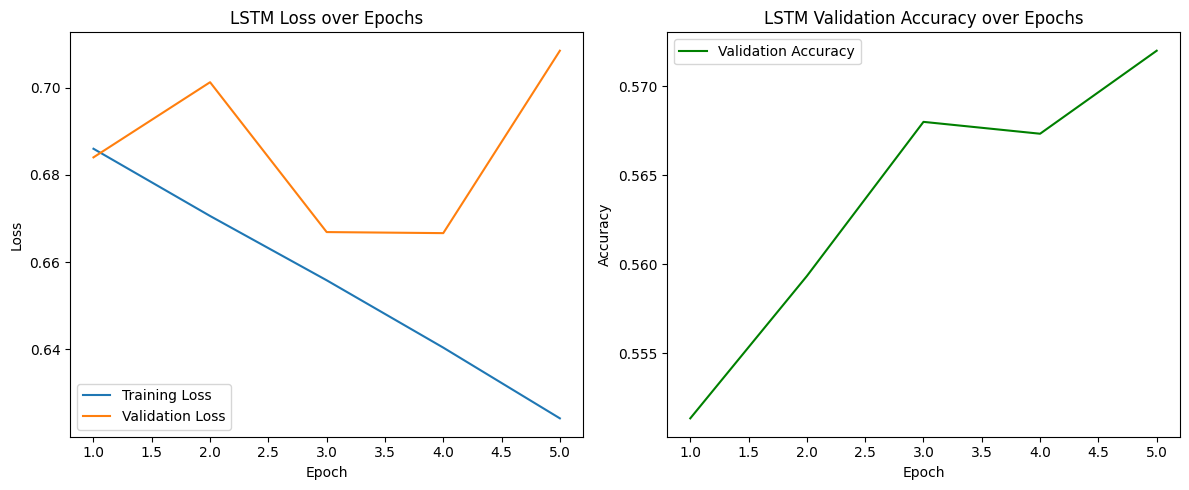

In [ ]:
#@title Plot Accuracy and Loss vs Epoch for LSTM
import matplotlib.pyplot as plt

# Plot Loss for LSTM
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(lstm_train_losses) + 1), lstm_train_losses, label='Training Loss')
plt.plot(range(1, len(lstm_val_losses) + 1), lstm_val_losses, label='Validation Loss')
plt.title('LSTM Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy for LSTM
plt.subplot(1, 2, 2)
plt.plot(range(1, len(lstm_val_accuracies) + 1), lstm_val_accuracies, label='Validation Accuracy', color='green')
plt.title('LSTM Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(f"{BASE_DIR}/{SAMPLE_NAME}/lstm_loss_accuracy_epochs.png")
plt.show()

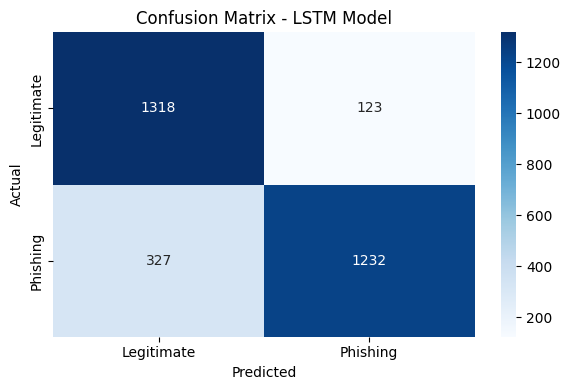

In [ ]:
#@title Generate Confusion Matrix for LSTM
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix for LSTM
cm_lstm = confusion_matrix(test_labels, lstm_preds)

# Plot Confusion Matrix for LSTM
plt.figure(figsize=(6,4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM Model')
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/{SAMPLE_NAME}/confusion_matrix_lstm.png")
plt.show()

In [ ]:
#@title Save LSTM Model
import torch

torch.save(lstm_model.state_dict(), f"{BASE_DIR}/{SAMPLE_NAME}/lstm_model.pt")
print("LSTM model saved to:", f"{BASE_DIR}/{SAMPLE_NAME}/lstm_model.pt")


LSTM model saved to: /content/drive/MyDrive/Detect_AI_Phishing_Project/sample1/lstm_model.pt


In [ ]:
#@title Train & Evaluate GRU Baseline

gru_model = GRUClassifier(vocab_size=MAX_VOCAB_SIZE)

(
    gru_model,
    gru_train_losses,
    gru_val_losses,
    gru_val_accuracies,
    gru_val_precisions,
    gru_val_recalls,
    gru_val_f1_scores
) = train_rnn(
    gru_model,
    train_loader_rnn,
    val_loader_rnn
)

# Evaluate on test set
gru_results = evaluate_rnn(gru_model, test_loader_rnn)

gru_metrics = gru_results["metrics"]
gru_preds   = gru_results["y_pred"]
gru_probs   = gru_results["y_prob"]

print("GRU Metrics:", gru_metrics)


Epoch 1, Train Loss: 0.6950, Val Loss: 0.6835, Val Accuracy: 0.5507
Epoch 2, Train Loss: 0.6203, Val Loss: 0.6021, Val Accuracy: 0.5680
Epoch 3, Train Loss: 0.5431, Val Loss: 0.6083, Val Accuracy: 0.7027
Epoch 4, Train Loss: 0.4613, Val Loss: 0.2561, Val Accuracy: 0.9200
Epoch 5, Train Loss: 0.1779, Val Loss: 0.1692, Val Accuracy: 0.9400
GRU Metrics: {'accuracy': 0.9396666666666667, 'precision': 0.9253086419753086, 'recall': 0.9615137908915972, 'f1': 0.9430638565586662}


In [ ]:
#@title Display & save GRU Epoch Metrics
import pandas as pd

# Create a DataFrame for GRU epoch metrics
gru_epoch_metrics_data = {
    'Epoch': list(range(1, len(gru_train_losses) + 1)),
    'Training Loss': gru_train_losses,
    'Validation Loss': gru_val_losses,
    'Validation Accuracy': gru_val_accuracies,
    'Validation Precision': gru_val_precisions,
    'Validation Recall': gru_val_recalls,
    'Validation F1': gru_val_f1_scores
}
gru_epoch_metrics_df = pd.DataFrame(gru_epoch_metrics_data)

# Save GRU epoch metrics to CSV
gru_epoch_metrics_path = f"{BASE_DIR}/{SAMPLE_NAME}/gru_epoch_metrics.csv"
gru_epoch_metrics_df.to_csv(gru_epoch_metrics_path, index=False)
print(f"GRU epoch metrics saved to: {gru_epoch_metrics_path}")

display(gru_epoch_metrics_df)

GRU epoch metrics saved to: /content/drive/MyDrive/Detect_AI_Phishing_Project/sample1/gru_epoch_metrics.csv


,Epoch,Training Loss,Validation Loss,Validation Accuracy,Validation Precision,Validation Recall,Validation F1
0,1,0.692859,0.684405,0.550667,0.539623,0.917843,0.679658
1,2,0.635940,0.572465,0.858000,0.938080,0.777920,0.850526
2,3,0.315862,0.206252,0.930000,0.916049,0.952503,0.933921
3,4,0.143198,0.123962,0.956000,0.958816,0.956354,0.957584
4,5,0.089535,0.131512,0.948667,0.960630,0.939666,0.950032


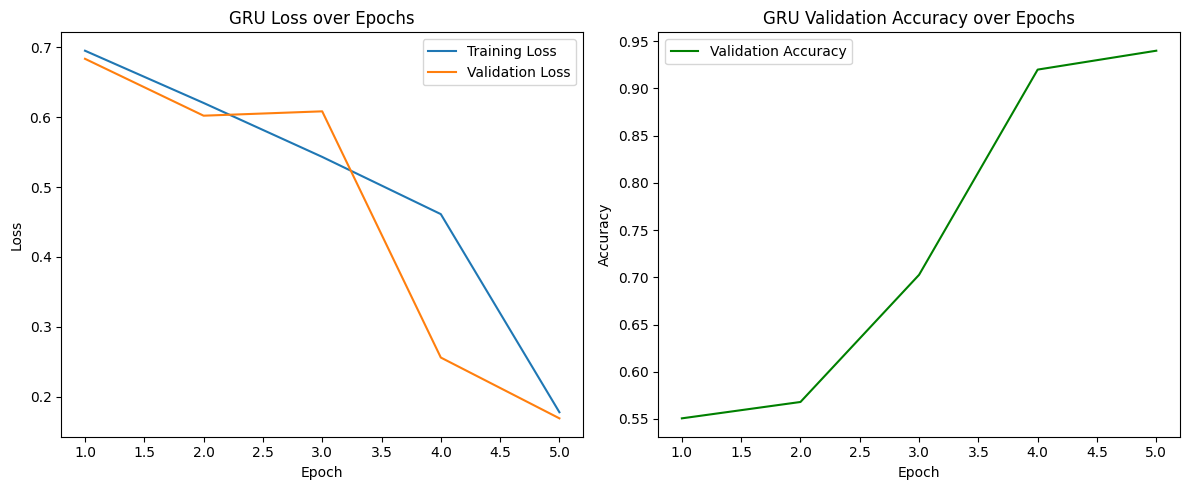

In [ ]:
#@title Plot Accuracy and Loss vs Epoch for GRU
import matplotlib.pyplot as plt

# Plot Loss for GRU
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(gru_train_losses) + 1), gru_train_losses, label='Training Loss')
plt.plot(range(1, len(gru_val_losses) + 1), gru_val_losses, label='Validation Loss')
plt.title('GRU Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy for GRU
plt.subplot(1, 2, 2)
plt.plot(range(1, len(gru_val_accuracies) + 1), gru_val_accuracies, label='Validation Accuracy', color='green')
plt.title('GRU Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(f"{BASE_DIR}/{SAMPLE_NAME}/gru_loss_accuracy_epochs.png")
plt.show()

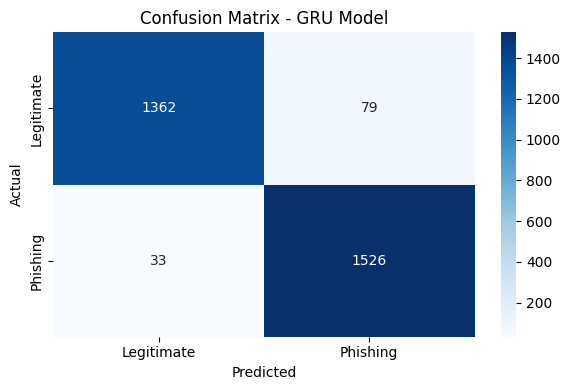

In [ ]:
#@title Generate Confusion Matrix for GRU
cm_gru = confusion_matrix(test_labels, gru_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - GRU Model')
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/{SAMPLE_NAME}/confusion_matrix_gru.png")
plt.show()

In [ ]:
#@title Save GRU Model
import torch

torch.save(gru_model.state_dict(), f"{BASE_DIR}/{SAMPLE_NAME}/gru_model.pt")
print("GRU model saved to:", f"{BASE_DIR}/{SAMPLE_NAME}/gru_model.pt")


GRU model saved to: /content/drive/MyDrive/Detect_AI_Phishing_Project/sample1/gru_model.pt


#### Tokenization using BERT Tokenizer

These encodings are the tokenized versions of your input texts, structured in a way that BERT can understand

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the datasets
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
print(train_encodings['input_ids'][0])          # View input IDs of the first text
print(train_encodings['attention_mask'][0])

[101, 12403, 4168, 2595, 4842, 3215, 3081, 10474, 21318, 12069, 23806, 9148, 12079, 9006, 8080, 2026, 2015, 4160, 2140, 6658, 7293, 6790, 2184, 10020, 1055, 1035, 4013, 4887, 20389, 10450, 8043, 2075, 20554, 1035, 25630, 2475, 1014, 12403, 4168, 2595, 4842, 3215, 12403, 4168, 2595, 4842, 3215, 3582, 8299, 2102, 9148, 12079, 9006, 13102, 14074, 2595, 4842, 3215, 7514, 4773, 8299, 2102, 9148, 12079, 9006, 4305, 2890, 6593, 1035, 7696, 16748, 8520, 4502, 4168, 2595, 4842, 3215, 4604, 3622, 4471, 3042, 10047, 12403, 4168, 2595, 4842, 3215, 4471, 2735, 10373, 26828, 2015, 8299, 2102, 9148, 12079, 9006, 6305, 3597, 16671, 17048, 9031, 2015, 10424, 2072, 5511, 15476, 2263, 8732, 23777, 2549, 2199, 2692, 3622, 4471, 12403, 4168, 2595, 4842, 3215, 3081, 4773, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

#### Convert to HuggingFace Dataset

A custom PyTorch dataset class for handling tokenized email text data and labels.

- **Inherits**: `torch.utils.data.Dataset`
- **Purpose**: Feeds input to Hugging Face `Trainer` in a structured format.

#### Methods:
- `__init__(self, encodings, labels)`
  - Stores tokenized input data (`encodings`) and labels.
- `__getitem__(self, idx)`
  - Returns the input tensors and label for a specific index.
  - Example output:
    ```python
    {
      'input_ids': tensor(...),
      'attention_mask': tensor(...),
      'labels': tensor(...)
    }
    ```
- `__len__(self)`
  - Returns the total number of samples.

    

#### Data input format for bert
- input_ids: Token IDs representing the input text.

- attention_mask: Binary mask to distinguish real tokens (1) from padding (0).

- labels: True class values used for supervised learning.

- [CLS]: Special token added at the start of input for classification tasks.

- [SEP]: Separator token marking the end of a sentence or segment.



In [ ]:
class EmailDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmailDataset(train_encodings, train_labels)
val_dataset = EmailDataset(val_encodings, val_labels)


#### Load Pretrained BERT for Classification

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define Evaluation Metrics

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


#### Training Arguments

`TrainingArguments` is a configuration class that defines how your model should be trained. You pass it key training parameters such as:

- `output_dir`: Where to save model checkpoints.
- `learning_rate`: Controls how fast the model learns.
- `num_train_epochs`: Number of complete passes through the training data.
- `evaluation_strategy`: When to run validation (e.g., `"epoch"` means after every epoch).
- `per_device_train_batch_size`: Batch size per GPU/CPU device during training.
- `logging_dir`: Directory to store training logs.

It does **not** train the model — it only stores training settings that the `Trainer` will use.



In [ ]:
training_args = TrainingArguments(
    output_dir=f"{BASE_DIR}/{SAMPLE_NAME}/bert/results",
    eval_strategy="epoch",       # Validates after each epoch
    save_strategy="epoch",             # Saves checkpoint after each epoch
    save_total_limit=2,                # Keep only last 2 checkpoints
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    optim="adamw_torch",
    logging_dir=f"{BASE_DIR}/{SAMPLE_NAME}/bert/logs",
    logging_strategy="epoch",          # Log once per epoch
    load_best_model_at_end=True,       # Optional: load best val score model
    metric_for_best_model="f1",        # Based on compute_metrics
    greater_is_better=True             # Because higher F1 is better
)


#### Trainer




`Trainer` is the training engine provided by Hugging Face. It handles the full model training lifecycle. Specifically, it:

- Loads and trains your model.
- Handles batching, shuffling, and tokenization.
- Trains the model using PyTorch under the hood.
- Evaluates the model on your `eval_dataset`.
- Uses the settings defined in `TrainingArguments`.
- Automatically supports training on GPU or TPU if available.

`Trainer` simplifies the process so you don’t need to manually write training loops, backpropagation, or optimizer logic.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

/tmp/ipython-input-3673888053.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


#### Train the BERT Model

The `trainer.train()` method is the command that **starts the training process** using the configuration and datasets you’ve defined with Hugging Face’s `Trainer` class.

It does the following:

- Loads the `train_dataset` and batches the data.
- Feeds each batch through the model.
- Computes the loss and performs backpropagation to update model weights.
- Evaluates the model on the `eval_dataset` if `evaluation_strategy` is set (e.g., `"epoch"`).
- Saves checkpoints if `save_strategy` is configured.
- Logs training metrics (loss, accuracy, etc.) if `logging_dir` is specified.

##### What It Uses Internally:
- Model defined in `Trainer(model=...)`
- Training configuration from `TrainingArguments`
- Tokenizer and data collator for handling padding and batching
- Evaluation function if `compute_metrics` is provided

##### Output:
After running `trainer.train()`, the model will be:
- Trained on your training data
- Optionally validated each epoch
- Saved to the directory specified in `output_dir`


In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 1


wandb: You chose 'Create a W&B account'
wandb: Create an account here: https://wandb.ai/authorize?signup=true&ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kushalshah0 (kushalshah0-kushal-shah) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.150200,0.114838,0.974667,0.975260,0.989432,0.961489
2,0.040600,0.069489,0.985333,0.985806,0.990921,0.980745
3,0.012000,0.109779,0.980000,0.980494,0.993412,0.967908
4,0.003600,0.090192,0.984667,0.985094,0.994764,0.975610
5,0.000400,0.080653,0.986000,0.986460,0.990933,0.982028


TrainOutput(global_step=3285, training_loss=0.04137846289522935, metrics={'train_runtime': 5393.5642, 'train_samples_per_second': 9.734, 'train_steps_per_second': 0.609, 'total_flos': 1.38133304064e+16, 'train_loss': 0.04137846289522935, 'epoch': 5.0})

In [ ]:
#@title Display & save BERT Epoch Metrics
import pandas as pd

# Create a DataFrame for BERT epoch metrics
bert_epoch_metrics_data = {
    'Epoch': epochs,
    'Training Loss': train_loss,
    'Validation Loss': eval_loss,
    'Accuracy': eval_acc,
    'F1': [entry['eval_f1'] for entry in log_history if 'eval_f1' in entry],
    'Precision': [entry['eval_precision'] for entry in log_history if 'eval_precision' in entry],
    'Recall': [entry['eval_recall'] for entry in log_history if 'eval_recall' in entry]
}
bert_epoch_metrics_df = pd.DataFrame(bert_epoch_metrics_data)

# Save BERT epoch metrics to CSV
bert_epoch_metrics_path = f"{BASE_DIR}/{SAMPLE_NAME}/bert_epoch_metrics.csv"
bert_epoch_metrics_df.to_csv(bert_epoch_metrics_path, index=False)
print(f"BERT epoch metrics saved to: {bert_epoch_metrics_path}")

display(bert_epoch_metrics_df)

BERT epoch metrics saved to: /content/drive/MyDrive/Detect_AI_Phishing_Project/sample1/bert_epoch_metrics.csv


,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,1,0.1502,0.114838,0.974667,0.975260,0.989432,0.961489
1,2,0.0406,0.069489,0.985333,0.985806,0.990921,0.980745
2,3,0.0120,0.109779,0.980000,0.980494,0.993412,0.967908
3,4,0.0036,0.090192,0.984667,0.985094,0.994764,0.975610
4,5,0.0004,0.080653,0.986000,0.986460,0.990933,0.982028


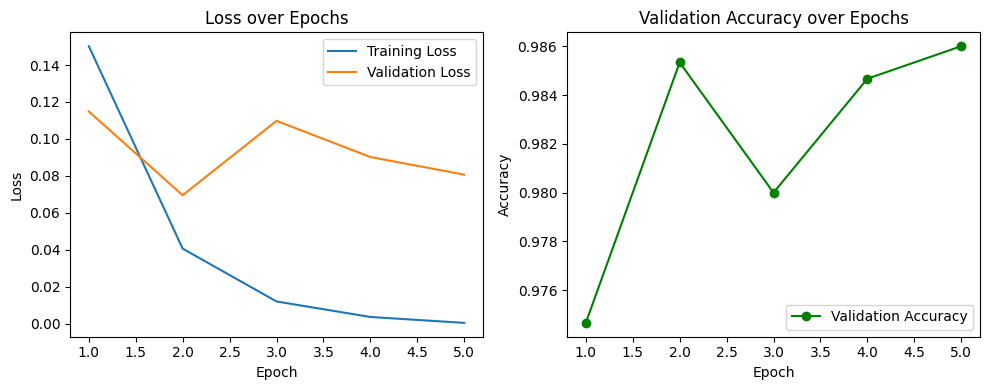

In [ ]:
#@title Plot Accuracy and Loss vs Epoch for BERT
import matplotlib.pyplot as plt

# Extract logs
log_history = trainer.state.log_history

# Gather data
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
eval_acc  = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry]
epochs = list(range(1, len(eval_loss)+1))

# Plot loss for bert
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, eval_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot accuracy for bert
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_acc, marker='o', color='green', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.savefig(f"{BASE_DIR}/{SAMPLE_NAME}/bert_loss_accuracy_epochs.png") # Save before showing
plt.show()

## Save the Final Model & Tokenizer

In [ ]:
# Save model and tokenizer
model.save_pretrained(f"{BASE_DIR}/{SAMPLE_NAME}/bert/final_model")
tokenizer.save_pretrained(f"{BASE_DIR}/{SAMPLE_NAME}/bert/final_model")


('/content/drive/MyDrive/Detect_AI_Phishing_Project/sample1/bert/final_model/tokenizer_config.json',
 '/content/drive/MyDrive/Detect_AI_Phishing_Project/sample1/bert/final_model/special_tokens_map.json',
 '/content/drive/MyDrive/Detect_AI_Phishing_Project/sample1/bert/final_model/vocab.txt',
 '/content/drive/MyDrive/Detect_AI_Phishing_Project/sample1/bert/final_model/added_tokens.json')

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
model = BertForSequenceClassification.from_pretrained(f"{BASE_DIR}/{SAMPLE_NAME}/bert/final_model")
tokenizer = BertTokenizer.from_pretrained(f"{BASE_DIR}/{SAMPLE_NAME}/bert/final_model")


### Test the model

##### Tokenize test data

In [ ]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

#### Convert to PyTorch Dataset

In [ ]:
test_dataset = EmailDataset(test_encodings, test_labels)

#### Evaluate Model on Test Set

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Run predictions on the test set
test_results = trainer.predict(test_dataset)

# Extract predicted class labels
y_pred = test_results.predictions.argmax(axis=1)
y_true = test_labels  # Make sure test_labels is a list of integers

# Print all core metrics
print("Final Test Evaluation Metrics:\n")
print("Accuracy       :", accuracy_score(y_true, y_pred))
print("Precision      :", precision_score(y_true, y_pred))
print("Recall         :", recall_score(y_true, y_pred))
print("F1 Score       :", f1_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Legitimate", "Phishing"]))



Final Test Evaluation Metrics:

Accuracy       : 0.9836666666666667
Precision      : 0.9864690721649485
Recall         : 0.9820397690827454
F1 Score       : 0.98424943747991

Classification Report:
               precision    recall  f1-score   support

  Legitimate       0.98      0.99      0.98      1441
    Phishing       0.99      0.98      0.98      1559

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



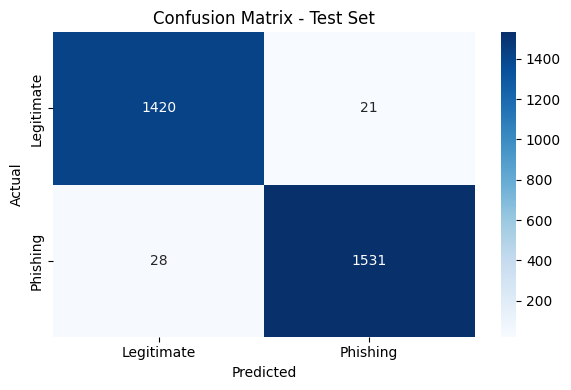

In [ ]:
# Plot confusion matrix
#@title Generate Confusion Matrix for BERT
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - BERT Model')
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/{SAMPLE_NAME}/confusion_matrix_bert.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_pred = test_results.predictions.argmax(axis=1)
print(classification_report(test_labels, y_pred, target_names=["Legitimate", "Phishing"]))


              precision    recall  f1-score   support

  Legitimate       0.98      0.99      0.98      1441
    Phishing       0.99      0.98      0.98      1559

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [ ]:
bert_metrics = {
    'accuracy': accuracy_score(y_true, y_pred),
    'precision': precision_score(y_true, y_pred),
    'recall': recall_score(y_true, y_pred),
    'f1': f1_score(y_true, y_pred)
}

In [ ]:
results_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'BERT'],
    'Accuracy': [lstm_metrics['accuracy'], gru_metrics['accuracy'], bert_metrics['accuracy']],
    'Precision': [lstm_metrics['precision'], gru_metrics['precision'], bert_metrics['precision']],
    'Recall': [lstm_metrics['recall'], gru_metrics['recall'], bert_metrics['recall']],
    'F1 Score': [lstm_metrics['f1'], gru_metrics['f1'], bert_metrics['f1']]
})

In [ ]:
#@title Display & Save Model Comparison Metrics
print('Model Comparison Metrics:')
display(results_df)
metrics_path = f"{BASE_DIR}/{SAMPLE_NAME}/model_comparison_metrics.csv"
results_df.to_csv(metrics_path, index=False)
print("Comparison metrics saved to:", metrics_path)

Model Comparison Metrics:


,Model,Accuracy,Precision,Recall,F1 Score
0,LSTM,0.850000,0.909225,0.790250,0.845573
1,GRU,0.962667,0.950779,0.978833,0.964602
2,BERT,0.983667,0.986469,0.982040,0.984249


In [ ]:
#@title Save Model Comparison Metrics
metrics_path = f"{BASE_DIR}/{SAMPLE_NAME}/model_comparison_metrics.csv"
results_df.to_csv(metrics_path, index=False)
print("Comparison metrics saved to:", metrics_path)

Comparison metrics saved to: /content/drive/MyDrive/Detect_AI_Phishing_Project/sample1/model_comparison_metrics.csv


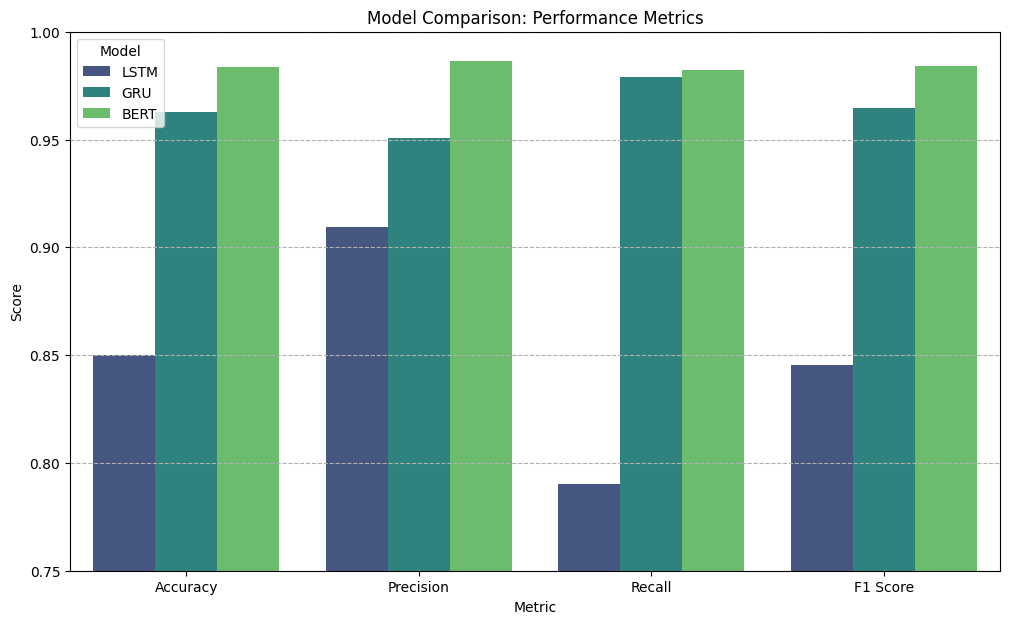

In [ ]:
#@title Generate Model Comparison Metrics Bar Chart
melted_results_df = results_df.melt(id_vars='Model', var_name='Metric', value_name='Value')
plt.figure(figsize=(12, 7))
sns.barplot(x='Metric', y='Value', hue='Model', data=melted_results_df, palette='viridis')
plt.title('Model Comparison: Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0.75, 1.0) # Set y-axis limit for better comparison of high scores
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--')
plt.savefig(f"{BASE_DIR}/{SAMPLE_NAME}/model_comparison_metrics.png")
plt.show()

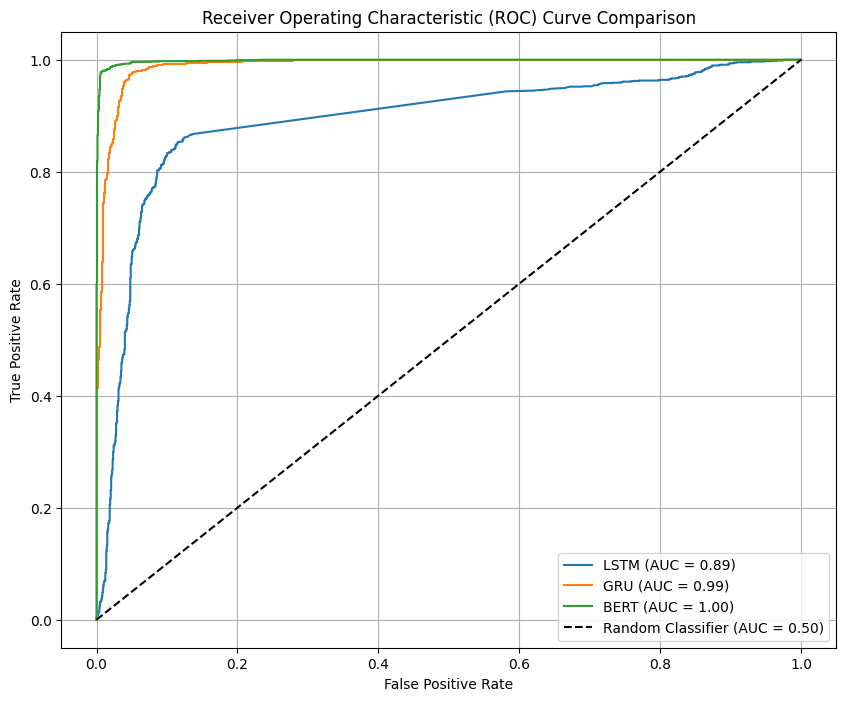

In [ ]:
#@title Generate roc_curve_comparison
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from scipy.special import softmax # For BERT logits

# 3. Define the true labels for the test set
y_true = y_test # y_test is already available from previous steps

# Prepare probabilities for each model
# LSTM and GRU probabilities are already calculated
lstm_positive_probs = lstm_probs
gru_positive_probs = gru_probs

# BERT probabilities: apply softmax to logits and get the probability of the positive class (index 1)
bert_logits = test_results.predictions
bert_positive_probs = softmax(bert_logits, axis=1)[:, 1]

# Create a dictionary to hold model names and their positive class probabilities
models_data = {
    'LSTM': lstm_positive_probs,
    'GRU': gru_positive_probs,
    'BERT': bert_positive_probs
}

# 2. Create a new figure for the plot
plt.figure(figsize=(10, 8))

# 4. For each model (LSTM, GRU, and BERT):
for model_name, probs in models_data.items():
    # a. Get the predicted probabilities (already done above)

    # b. Calculate the False Positive Rate (fpr), True Positive Rate (tpr), and thresholds
    fpr, tpr, thresholds = roc_curve(y_true, probs)

    # c. Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    # d. Plot the ROC curve for the current model
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# 5. Plot a diagonal dashed line from (0,0) to (1,1)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')

# 6. Add a title to the plot
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')

# 7. Label the x-axis and y-axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# 8. Add a legend
plt.legend(loc='lower right')

# 9. Display the plot
plt.grid(True)
plt.savefig(f"{BASE_DIR}/{SAMPLE_NAME}/roc_curve_comparison.png")
plt.show()

## Test Models with User Provided Texts

In [10]:
import torch
import torch.nn as nn
import pickle
from transformers import BertTokenizer, BertForSequenceClassification
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.special import softmax
import os # Import os for os.path.join

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define BASE_DIR and SAMPLE_NAME here as they are needed for loading models
BASE_DIR = "/content/drive/MyDrive/Detect_AI_Phishing_Project"
SAMPLE_NAME = "sample1"

# Load RNN Tokenizer
MAX_VOCAB_SIZE = 20000 # Must match the one used during training
MAX_SEQ_LEN = 300      # Must match the one used during training

rnn_tokenizer_path = f"{BASE_DIR}/{SAMPLE_NAME}/rnn_tokenizer.pkl"
with open(rnn_tokenizer_path, "rb") as f:
    tokenizer_rnn = pickle.load(f)

# Load LSTM model
lstm_model = LSTMClassifier(vocab_size=MAX_VOCAB_SIZE)
lstm_model.load_state_dict(torch.load(f"{BASE_DIR}/{SAMPLE_NAME}/lstm_model.pt", map_location=device))
lstm_model.to(device)
lstm_model.eval() # Set to evaluation mode

# Load GRU model
gru_model = GRUClassifier(vocab_size=MAX_VOCAB_SIZE)
gru_model.load_state_dict(torch.load(f"{BASE_DIR}/{SAMPLE_NAME}/gru_model.pt", map_location=device))
gru_model.to(device)
gru_model.eval() # Set to evaluation mode

# Load BERT model and tokenizer
bert_model_path = f"{BASE_DIR}/{SAMPLE_NAME}/bert/final_model"
bert_model = BertForSequenceClassification.from_pretrained(bert_model_path)
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_path)
bert_model.to(device)
bert_model.eval() # Set to evaluation mode

print("Models and tokenizers loaded successfully!")

Models and tokenizers loaded successfully!


### Preprocessing Functions for User Input

In [11]:
# Preprocessing for RNN models (LSTM/GRU)
def preprocess_rnn_text(text):
    # Apply the same lowercasing as during training
    processed_text = text.lower()
    sequences = tokenizer_rnn.texts_to_sequences([processed_text])
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")
    return torch.tensor(padded_sequences, dtype=torch.long)

# Preprocessing for BERT model
def preprocess_bert_text(text):
    # BERT tokenizer handles lowercasing internally if it was trained that way (bert-base-uncased)
    encodings = bert_tokenizer(text, truncation=True, padding=True, return_tensors='pt')
    return encodings['input_ids'], encodings['attention_mask']

### Prediction Functions

In [12]:
def predict_rnn(model, text):
    model.eval()
    with torch.no_grad():
        input_tensor = preprocess_rnn_text(text).to(device)
        outputs = model(input_tensor)
        prediction = (outputs.squeeze() > 0.5).int().item()
        probability = outputs.squeeze().item()
    return prediction, probability

def predict_bert(model, text):
    model.eval()
    with torch.no_grad():
        input_ids, attention_mask = preprocess_bert_text(text)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = softmax(logits.cpu().numpy(), axis=1)[0]
        predicted_class = torch.argmax(logits, dim=1).item()
        predicted_probability = probabilities[1] # Probability of phishing (class 1)
    return predicted_class, predicted_probability

### Example Usage

In [13]:
phishing_email_example = (
    "Urgent: Your account has been compromised. Please click here to verify your details immediately "
    "or your account will be suspended: http://bit.ly/malicious-link.  Ignore this warning at your own risk."
)

legitimate_email_example = (
    "Dear Customer, your order #12345 has shipped and will arrive by October 26th. "
    "Track your package here: https://www.example.com/track. Thank you for your business."
)

def interpret_prediction(prediction):
    return "Phishing" if prediction == 1 else "Legitimate"

print("\n--- Testing Phishing Email Example ---")
# LSTM Prediction
lstm_pred, lstm_prob = predict_rnn(lstm_model, phishing_email_example)
print(f"LSTM Prediction: {interpret_prediction(lstm_pred)} (Probability: {lstm_prob:.4f})")

# GRU Prediction
gru_pred, gru_prob = predict_rnn(gru_model, phishing_email_example)
print(f"GRU Prediction: {interpret_prediction(gru_pred)} (Probability: {gru_prob:.4f})")

# BERT Prediction
bert_pred, bert_prob = predict_bert(bert_model, phishing_email_example)
print(f"BERT Prediction: {interpret_prediction(bert_pred)} (Probability: {bert_prob:.4f})")

print("\n--- Testing Legitimate Email Example ---")
# LSTM Prediction
lstm_pred, lstm_prob = predict_rnn(lstm_model, legitimate_email_example)
print(f"LSTM Prediction: {interpret_prediction(lstm_pred)} (Probability: {lstm_prob:.4f})")

# GRU Prediction
gru_pred, gru_prob = predict_rnn(gru_model, legitimate_email_example)
print(f"GRU Prediction: {interpret_prediction(gru_pred)} (Probability: {gru_prob:.4f})")

# BERT Prediction
bert_pred, bert_prob = predict_bert(bert_model, legitimate_email_example)
print(f"BERT Prediction: {interpret_prediction(bert_pred)} (Probability: {bert_prob:.4f})")


--- Testing Phishing Email Example ---
LSTM Prediction: Phishing (Probability: 0.8166)
GRU Prediction: Phishing (Probability: 0.9895)
BERT Prediction: Phishing (Probability: 0.9969)

--- Testing Legitimate Email Example ---
LSTM Prediction: Legitimate (Probability: 0.3917)
GRU Prediction: Phishing (Probability: 0.9780)
BERT Prediction: Legitimate (Probability: 0.0322)


## Prediction Tool

In [28]:
email_text = "Dear Customer, your order #12345 has shipped and will arrive by October 26th. " #@param {type:"string"}
model_selector = "bert" #@param ["bert", "lstm", "gru"]

print(f"Predicting with {model_selector.upper()} model...")
try:
    if not email_text.strip(): # Check if email_text is empty or just whitespace
        print("Please enter some text to make a prediction.")
    elif model_selector not in ["bert", "lstm", "gru"]:
        print("Invalid model selected.")
    else:
        if model_selector == 'lstm':
            pred, prob = predict_rnn(lstm_model, email_text)
        elif model_selector == 'gru':
            pred, prob = predict_rnn(gru_model, email_text)
        elif model_selector == 'bert':
            pred, prob = predict_bert(bert_model, email_text)

        result = interpret_prediction(pred)
        color = 'green' if result == 'Legitimate' else 'red'
        print(f"Prediction: {result} (Probability: {prob:.4f})")

except Exception as e:
    print(f"An error occurred during prediction: {e}")

Predicting with BERT model...
Prediction: Legitimate (Probability: 0.1347)
